In [5]:
import json
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
from dotenv import load_dotenv
from PIL import Image as PILImage

## 1. Azure Computer Vision 4.0 Florence connection

In [9]:
load_dotenv("azure.env")

acv_key = os.getenv("acv_key")
acv_endpoint = os.getenv("acv_endpoint")

# The azure endpoint should not finished a /
if acv_endpoint.endswith("/"):
    acv_endpoint= acv_endpoint[:-1]

## 2. Functions

In [10]:
def image_url_embedding(imageurl):
    """
    Url image vector embeddings using Azure Computer Vision 4
    """
    version = "?api-version=2023-02-01-preview&modelVersion=latest"
    vec_img_url = acv_endpoint + "/computervision/retrieval:vectorizeImage" + version
    headers = {"Content-type": "application/json", "Ocp-Apim-Subscription-Key": acv_key}

    image = {"url": imageurl}
    r = requests.post(vec_img_url, data=json.dumps(image), headers=headers)
    
    if r.status_code == 200:
        image_emb = r.json()["vector"]
        return image_emb
    
    else:
        print(f"Error: {r.status_code} - {r.text}")
        return None

In [11]:
def text_embedding(promptxt):
    """
    Text vector embedding text using using Azure Computer Vision 4
    """
    version = "?api-version=2023-02-01-preview&modelVersion=latest"
    vec_txt_url = acv_endpoint + "/computervision/retrieval:vectorizeText" + version
    headers = {"Content-type": "application/json", "Ocp-Apim-Subscription-Key": acv_key}

    prompt = {"text": promptxt}
    r = requests.post(vec_txt_url, data=json.dumps(prompt), headers=headers)
    
    if r.status_code == 200:
        text_emb = r.json()["vector"]
        return text_emb
    
    else:
        print(f"Error: {r.status_code} - {r.text}")
        return None

In [12]:
def get_cosine_similarity(vector1, vector2):
    """
    Get cosine similarity value between two embedded vectors
    """
    dot_product = sum(x * y for x, y in zip(vector1, vector2))
    magnitude1 = math.sqrt(sum(x * x for x in vector1))
    magnitude2 = math.sqrt(sum(x * x for x in vector2))
    cosine_similarity = dot_product / (magnitude1 * magnitude2)

    return round(cosine_similarity, 10)

In [13]:
def similarity_results(image_emb, prompts):
    """ 
    Get similarity results
    """
    simil_values_list = []
    for prompt in prompts:
        text_emb = text_embedding(prompt)
        if text_emb is None:
            print(f"Error: Unable to generate embedding for prompt: {prompt}")
            continue  # Skip this prompt if an error occurs
        simil_values_list.append(get_cosine_similarity(image_emb, text_emb))
    
    sorted_results = sorted(
        zip(prompts, simil_values_list), key=lambda x: x[1], reverse=True
    )

    df = pd.DataFrame(columns=["prompt", "cosine_similarity"])

    for idx, (prompt, simil_val) in enumerate(sorted_results):
        df.loc[idx, "prompt"] = prompt
        df.loc[idx, "cosine_similarity"] = simil_val

    df["cosine_similarity"] = df.cosine_similarity.astype(float)

    return df

## 3. Image and prompts

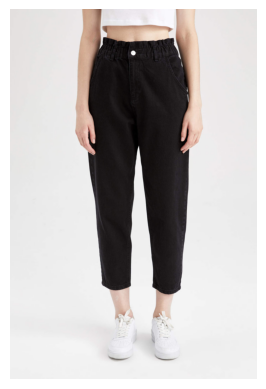

In [14]:
image_url = "https://dfcdn.defacto.com.tr/3/Z2821AZ_22WN_NM40_01_01.jpg"

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

In [15]:
embeddings = image_url_embedding(image_url)
print("Size of the vector embeddings =", len(embeddings))

Size of the vector embeddings = 1024


In [16]:
text = text_embedding("fit yüksek bel jean pantolon")

In [17]:
get_cosine_similarity(embeddings, text)

0.3349313428

## 4. Multiple prompts

In [18]:
prompts = [
    "fit yüksek bel jean pantolon",
    "fit bisiklet yaka çiçek baskılı kısa kollu tişört.",
    "fit esnek bel bilek boy pantolon",
]

In [20]:
df = similarity_results(embeddings, prompts)
df

,prompt,cosine_similarity
0,fit yüksek bel jean pantolon,0.334931
1,fit esnek bel bilek boy pantolon,0.286889
2,fit bisiklet yaka çiçek baskılı kısa kollu tiş...,0.200971


In [21]:
df.values.tolist()[0]

['fit yüksek bel jean pantolon', 0.3349313428]

### Example 2

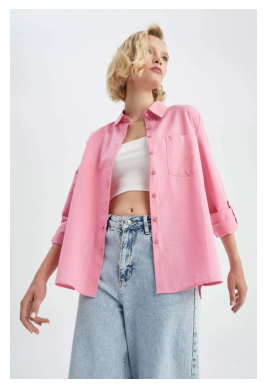

In [22]:
image_url = "https://dfcdn.defacto.com.tr/3/W7734AZ_22SM_PN82_01_02.jpg"
embeddings = image_url_embedding(image_url)

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

In [23]:
prompts = [
    "Kazak",
    "Kırmızı Elbise",
    "Kadın regular fit siyah gömlek",
    "Kadın regular fit tek cepli uzun kollu gömlek",
    "Mini etek",
]

In [25]:
df = similarity_results(embeddings, prompts)

df

,prompt,cosine_similarity
0,Kadın regular fit tek cepli uzun kollu gömlek,0.293838
1,Kadın regular fit siyah gömlek,0.284943
2,Mini etek,0.262083
3,Kırmızı Elbise,0.232213
4,Kazak,0.216429


## 4. Images similarity with vectors embeddings

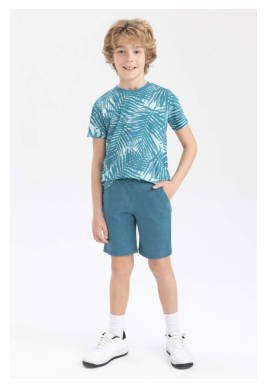

In [26]:
image_url = "https://dfcdn.defacto.com.tr/3/Z6372A6_23SM_BE508_01_02.jpg"
productA = image_url_embedding(image_url)

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

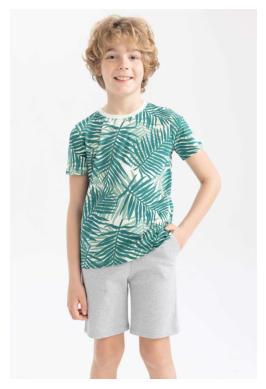

In [27]:
image_url = "https://dfcdn.defacto.com.tr/3/Z6372A6_23SM_TR319_01_02.jpg"
productB = image_url_embedding(image_url)

plt.imshow(PILImage.open(requests.get(image_url, stream=True).raw))
plt.axis("off")
plt.show()

In [28]:
def image_comparison(cosine):
    if round(cosine, 2) == 1:
        print("\033[1;31;34m")
        print("Result: Same image")

    elif cosine >= 0.7:
        print("\033[1;31;32m")
        print("Result: Almost similar image")

    else:
        print("\033[1;31;91m")
        print("Result: Different image")

    print("Cosine similarity =", cosine)

In [29]:
cosine = get_cosine_similarity(productA, productB)
image_comparison(cosine)


Result: Almost similar image
Cosine similarity = 0.9273780311
